In [1]:
# # Importing the data, normalizing and seperating into training and testing sets
import netCDF4 as nc
import numpy as np
from keras.models import load_model
from PIL import Image

# # Loading in the normalized dataset
all_input_data = np.array(nc.Dataset('cleaned_normalized_input_ds_2000_01_01_to_2018_12_31.nc','r').variables['data'][:])
all_target_data = nc.Dataset('cleaned_target_ds_2000_01_01_to_2018_12_31.nc', 'r').variables['data'][:]
all_input_max_norm = all_input_data
all_input_max_norm[all_input_max_norm < -4 ] = -4
all_input_max_norm[all_input_max_norm >  4 ] =  4
all_input_data = all_input_max_norm/4
del all_input_max_norm

# selecting the random indices for training and testing
np.random.seed(22) # setting the seed
num_days = np.shape(all_target_data)
num_days = num_days[0]
all_indices = np.arange(0, num_days)
train_indices = np.random.choice(np.arange(0, num_days), size=int(np.floor(num_days*.9)), replace=False)
test_indices = np.setdiff1d(all_indices, train_indices)

test_input = all_input_data[test_indices,:,:,:,:]
test_target = all_target_data[test_indices,:,]

# Loading the model and using it to make predictions
model = load_model('trained_Conv3D_model_04b.keras')
predictions = model.predict(test_input)

# Opening a sample tiff target for shape
test_image = Image.open("target_pr/rainfall_new_day_statewide_data_map_2019_01_01.tif")

# Convert the image to numpy array
image_array = np.array(test_image)

# Finding the relevant pixels in the image, ie just the island pixels
mask = image_array >= 0
mask_vec = mask.flatten()
target_indices = np.where(mask_vec)[0]
vector_size = np.size(mask)
recon_vec_perm = np.full(vector_size, np.nan)

2024-05-09 21:10:43.466561: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 21:10:43.467336: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 21:10:43.470460: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 21:10:43.517366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 21:10:44.649527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [8]:
print(np.shape(all_input_data))
print(np.shape(all_target_data))

(6574, 4, 100, 100, 5)
(6574, 287983)


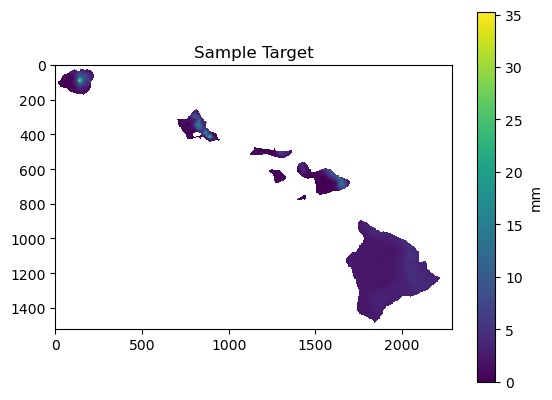

In [7]:
import matplotlib.pyplot as plt
image_array[image_array<0] = np.NaN
plt.imshow(image_array)
c = plt.colorbar()
c.set_label('mm')
plt.title('Sample Target')
plt.show()

In [4]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import imageio.v2 as imagio
import io

images = []
# num_examples = test_target.shape[0]
num_examples = 2
for i in tqdm(range(0, num_examples), desc='Processing files', unit='file'):
    sample_day = i
    recon_vec_real = np.full(vector_size, np.nan)
    recon_vec_pred = np.full(vector_size, np.nan)
    
    recon_vec_real[target_indices] = test_target[sample_day,:]
    recon_map_real = recon_vec_real.reshape(mask.shape)
    
    recon_vec_pred[target_indices] = predictions[sample_day,:]
    recon_map_pred = recon_vec_pred.reshape(mask.shape)
    
    fig, axs = plt.subplots(2, 2)
    clim_up_bnd = 25
    
    f1 = axs[0,0].imshow(recon_map_real, cmap='viridis', vmin=0, vmax=clim_up_bnd)
    axs[0,0].set_title('Real Daily Precip '+str(sample_day+1))
    cb1 = fig.colorbar(f1, ax=axs[0, 0])
    cb1.set_label('mm')
    
    f2 = axs[0,1].imshow(recon_map_pred, cmap='viridis', vmin=0, vmax=clim_up_bnd)
    axs[0,1].set_title('Pred. Daily Precip '+str(sample_day+1))
    cb2 = fig.colorbar(f2, ax=axs[0, 1])
    cb2.set_label('mm')
    
    f3 = axs[1,0].imshow(recon_map_real-recon_map_pred, cmap='BrBG', vmin=-10, vmax=10)
    axs[1,0].set_title('Real - Pred. '+str(sample_day+1))
    cb3 = fig.colorbar(f3, ax=axs[1,0])
    cb3.set_label('mm')
    
    f4 = axs[1,1].imshow((recon_map_real-recon_map_pred)**2, cmap='viridis', vmin=0, vmax=clim_up_bnd*2)
    axs[1,1].set_title('$(Real - Pred.)^2$ '+str(sample_day+1))
    cb4 = fig.colorbar(f4, ax=axs[1,1])
    cb4.set_label('mm')

    buf = io.BytesIO()
    plt.savefig(buf, format='png',dpi=300)
    buf.seek(0)
    images.append(imageio.imread(buf))
    plt.close()

# imageio.mimsave("Conv3D_pr_04b.gif", images, format='GIF', fps=2)


Processing files:   0%|          | 0/2 [00:00<?, ?file/s]/tmp/ipykernel_132172/2084436960.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(buf))
Processing files: 100%|██████████| 2/2 [00:03<00:00,  1.59s/file]


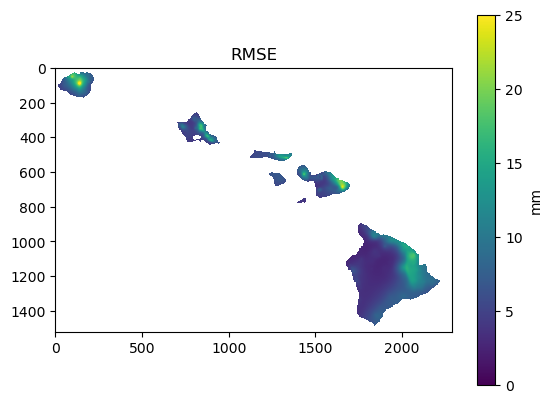

In [6]:
rmse = np.sqrt(np.mean(np.square(test_target - predictions),axis=0))
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = rmse
rmse_map = recon_rmse.reshape(mask.shape)

# Plotting the RMSE
f1 = plt.imshow(rmse_map, cmap='viridis', vmin=0, vmax=25)
plt.title('RMSE')
cb1 = fig.colorbar(f1)
cb1.set_label('mm')
plt.show()

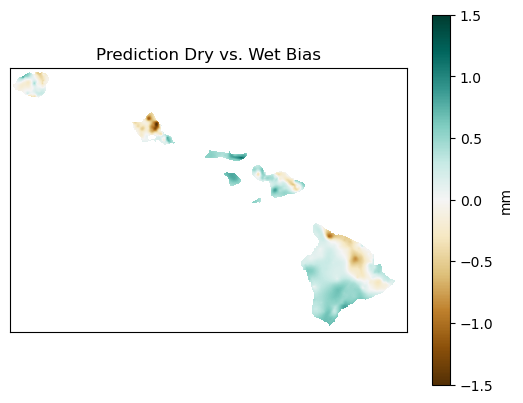

In [50]:
rmse_day = np.sqrt(np.square(test_target - predictions))
rmse_avgs = []
rmse_maxs = []
rmse_mins = []
diff = []
for i in range(0,len(rmse_day)):
    tmp_rmse = rmse_day[i,:]
    tmp_avg = np.mean(tmp_rmse)
    tmp_max = np.max(tmp_rmse)
    tmp_min = np.min(tmp_rmse)

    rmse_avgs = np.append(rmse_avgs,tmp_avg)
    rmse_maxs = np.append(rmse_maxs,tmp_max)
    rmse_mins = np.append(rmse_mins,tmp_min)

diff = test_target-predictions

diff_row_mean = np.mean(diff,axis=0)
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = diff_row_mean
bias_map = recon_rmse.reshape(mask.shape) 

plt.imshow(bias_map, cmap='BrBG', vmin=-1.5, vmax=1.5)
c = plt.colorbar()
c.set_label('mm')
plt.title('Prediction Dry vs. Wet Bias')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.savefig('prediction_dry_wet_bias_per_grid.png', dpi=300)
plt.show()

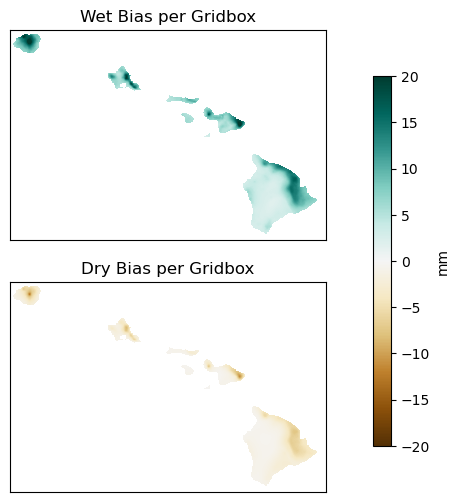

In [51]:
import copy

tmp_wetb = copy.deepcopy(diff)
tmp_wetb[tmp_wetb<=0] = 0
tmp_wetb_n = np.count_nonzero(tmp_wetb,axis=0)
tmp_wetb = np.sum(tmp_wetb,axis=0)/tmp_wetb_n

tmp_dryb = copy.deepcopy(diff)
tmp_dryb[tmp_dryb>=0] = 0
tmp_dryb_n = np.count_nonzero(tmp_dryb,axis=0)
tmp_dryb = np.sum(tmp_dryb,axis=0)/tmp_dryb_n

recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = tmp_dryb
dry_bias_map = recon_rmse.reshape(mask.shape)

recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = tmp_wetb
wet_bias_map = recon_rmse.reshape(mask.shape)

# Set the common clim value
clim = 20

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the first subplot
plt.subplot(2, 1, 1)
plt.imshow(wet_bias_map, cmap='BrBG', vmin=-clim, vmax=clim)
plt.title('Wet Bias per Gridbox')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Plot the second subplot
plt.subplot(2, 1, 2)
plt.imshow(dry_bias_map, cmap='BrBG', vmin=-clim, vmax=clim)
plt.title('Dry Bias per Gridbox')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

cbar = plt.colorbar(ax=plt.gcf().get_axes(), orientation='vertical', shrink=0.8)  # Adjust shrink as needed
cbar.set_label('mm')

# Show the plot
plt.savefig('wet_v_dry_per_gridbox.png', dpi=300)
plt.show()

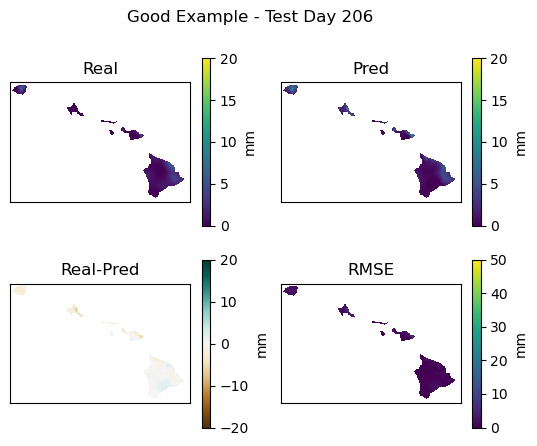

In [52]:
# Calculate RMSE for reconstructed data
rmse_maxs_min = np.min(rmse_maxs)
rmse_maxs_min_idx = np.argmin(rmse_maxs)
rmse_maxs_max =  np.max(rmse_maxs)
rmse_maxs_max_idx = np.argmax(rmse_maxs)

recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = rmse_day[rmse_maxs_min_idx, :]
rmse_best_map = recon_rmse.reshape(mask.shape)

# Plot Good RMSE
plt.subplot(224)
plt.imshow(rmse_best_map, cmap='viridis', vmin=0, vmax=50)
c = plt.colorbar()
c.set_label('mm')
plt.title('RMSE')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Calculate RMSE for predictions
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = predictions[rmse_maxs_min_idx, :]
pred_best_map = recon_rmse.reshape(mask.shape)

# Plot Predictions
plt.subplot(222)
plt.imshow(pred_best_map, cmap='viridis', vmin=0, vmax=20)
c = plt.colorbar()
c.set_label('mm')
plt.title('Pred')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Calculate RMSE for real data
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = test_target[rmse_maxs_min_idx, :]
real_best_map = recon_rmse.reshape(mask.shape)

# Plot Real
plt.subplot(221)
plt.imshow(real_best_map, cmap='viridis', vmin=0, vmax=20)
c = plt.colorbar()
c.set_label('mm')
plt.title('Real')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Plot Real-Pred difference
plt.subplot(223)
plt.imshow(real_best_map - pred_best_map, cmap='BrBG', vmin=-20, vmax=20)
c = plt.colorbar()
c.set_label('mm')
plt.title('Real-Pred')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.suptitle('Good Example - Test Day '+str(rmse_maxs_min_idx))
plt.savefig('Good_Example.png', dpi=300)
plt.show()

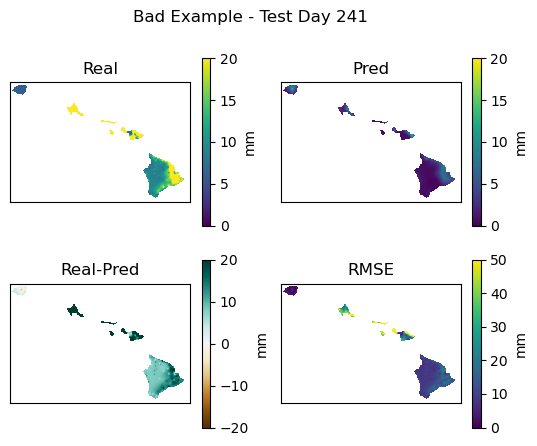

In [53]:
# Calculate RMSE for reconstructed data
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = rmse_day[rmse_maxs_max_idx, :]
rmse_best_map = recon_rmse.reshape(mask.shape)

# Plot Good RMSE
plt.subplot(224)
plt.imshow(rmse_best_map, cmap='viridis', vmin=0, vmax=50)
c = plt.colorbar()
c.set_label('mm')
plt.title('RMSE')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Calculate RMSE for predictions
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = predictions[rmse_maxs_max_idx, :]
pred_best_map = recon_rmse.reshape(mask.shape)

# Plot Predictions
plt.subplot(222)
plt.imshow(pred_best_map, cmap='viridis', vmin=0, vmax=20)
c = plt.colorbar()
c.set_label('mm')
plt.title('Pred')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Calculate RMSE for real data
recon_rmse = np.full(vector_size, np.nan)
recon_rmse[target_indices] = test_target[rmse_maxs_max_idx, :]
real_best_map = recon_rmse.reshape(mask.shape)

# Plot Real
plt.subplot(221)
plt.imshow(real_best_map, cmap='viridis', vmin=0, vmax=20)
c = plt.colorbar()
c.set_label('mm')
plt.title('Real')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Plot Real-Pred difference
plt.subplot(223)
plt.imshow(real_best_map - pred_best_map, cmap='BrBG', vmin=-20, vmax=20)
c = plt.colorbar()
c.set_label('mm')
plt.title('Real-Pred')
plt.setp(plt.gca(), xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.suptitle('Bad Example - Test Day '+str(rmse_maxs_max_idx))
plt.savefig('Bad_Example.png', dpi=300)
plt.show()